### Callback API Task

In [1]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print("train dataset shape:", train_images.shape, train_labels.shape)
print("test dataset shape:", test_images.shape, test_labels.shape)

train dataset shape: (60000, 28, 28) (60000,)
test dataset shape: (10000, 28, 28) (10000,)


In [2]:
from tensorflow.keras.layers import Layer, Input, Flatten, Dense
from tensorflow.keras.models import Model

INPUT_SIZE = 28

def create_model():
    input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE))
    x = Flatten()(input_tensor)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    return model

In [3]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np


def get_preprocessed_data(images, targets):
    images = np.array(images / 255.0, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)

    return images, targets

def get_preprocessed_ohe(images, targets):
    images, targets = get_preprocessed_data(images, targets)
    oh_targets = to_categorical(targets)

    return images, oh_targets

def get_train_valid_test(train_images, train_targets, test_images, test_targets, validation_size=0.2, random_state=124):
    train_images, train_oh_targets = get_preprocessed_ohe(train_images, train_targets)
    test_images, test_oh_targets = get_preprocessed_ohe(test_images, test_targets)

    train_images, validation_images, train_oh_targets, validation_oh_targets = \
    train_test_split(train_images, train_oh_targets, stratify=train_oh_targets, test_size=validation_size, random_state=random_state)

    return (train_images, train_oh_targets), (validation_images, validation_oh_targets), (test_images, test_oh_targets)

In [4]:
(train_images, train_oh_targets), (validation_images, validation_oh_targets), (test_images, test_oh_targets) = \
get_train_valid_test(train_images, train_labels, test_images, test_labels)

print(train_images.shape, train_oh_targets.shape)
print(validation_images.shape, validation_oh_targets.shape)
print(test_images.shape, test_oh_targets.shape)

(48000, 28, 28) (48000, 10)
(12000, 28, 28) (12000, 10)
(10000, 28, 28) (10000, 10)


In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model = create_model()
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/task/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    # 모든 epoch의 파일을 저장하지 않고 좋은 성능이라 판단될 경우만 저장할 때 True 설정
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

history = model.fit(x=train_images, y=train_oh_targets, 
                    validation_data=(validation_images, validation_oh_targets), 
                    epochs=20, batch_size=64, callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.8348 - loss: 0.5907 - val_acc: 0.9442 - val_loss: 0.1857 - learning_rate: 0.0010
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.9524 - loss: 0.1557 - val_acc: 0.9553 - val_loss: 0.1451 - learning_rate: 0.0010
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.9668 - loss: 0.1096 - val_acc: 0.9648 - val_loss: 0.1155 - learning_rate: 0.0010
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.9741 - loss: 0.0853 - val_acc: 0.9678 - val_loss: 0.1033 - learning_rate: 0.0010
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.9792 - loss: 0.0676 - val_acc: 0.9695 - val_loss: 0.0978 - learning_rate: 0.0010
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.9826 - loss: 0.0542 - val_acc: 0.9704 - val_loss: 0.0936 - learning_rate: 0.0010
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.9865 - loss: 0.0451 - val_acc: 0.9723 - val_loss: 0.0892 - learning_rate: 0.0010
Epoch 

In [7]:
model.evaluate(test_images, test_oh_targets)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - acc: 0.9768 - loss: 0.0816


[0.07269301265478134, 0.9785000085830688]

In [8]:
loaded_model = create_model()
loaded_model.load_weights('./callback_files/task/weights.014-0.0771-0.9989.weights.h5')

loaded_model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

loaded_model.evaluate(test_images, test_oh_targets)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - acc: 0.9768 - loss: 0.0816


[0.07269301265478134, 0.9785000085830688]

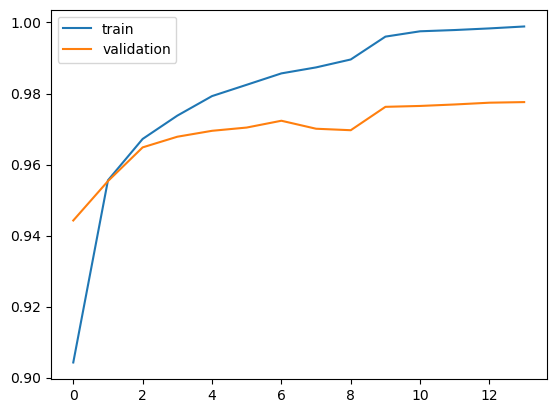

In [9]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

show_history(history)

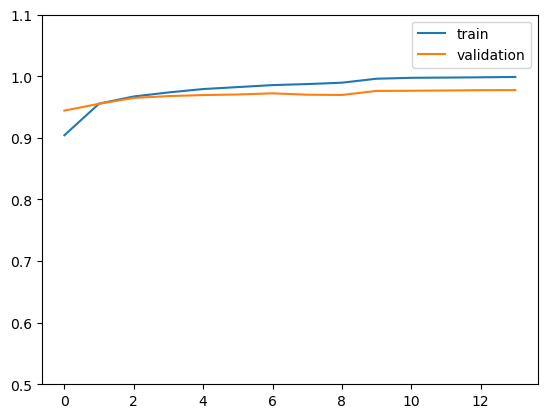

In [11]:
import matplotlib.pyplot as plt

def show_history_with_ylim(history):
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.ylim(0.5, 1.1)
    plt.legend()
    plt.show()

show_history_with_ylim(history)